# NLP Transformers, Vision Transformers

## Part 1 - Original Transformers for NLP

In [1]:
%%capture
!pip install tensorflow==2.15.0

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

max_len = 200
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)

17464789/17464789 [==============================] - 2s 0us/step


In [4]:
from tensorflow.keras import layers

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [6]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed-forward network inside the transformer
vocab_size = 20000

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)            #TODO add global average pooling
x = layers.Dropout(0.6)(x)                        #TODO add dropout
x = layers.Dense(20, activation='relu')(x)       #TODO add dense layer with about 20 neurons
x = layers.Dropout(0.6)(x)                        #TODO add dropout
outputs = layers.Dense(1, activation='sigmoid')(x)  #TODO add the final dense layer for classification

model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [8]:
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
782/782 [==============================] - 77s 89ms/step - loss: 0.5282 - accuracy: 0.7150 - val_loss: 0.3093 - val_accuracy: 0.8668
Epoch 2/10
782/782 [==============================] - 22s 28ms/step - loss: 0.2764 - accuracy: 0.9035 - val_loss: 0.3034 - val_accuracy: 0.8756
Epoch 3/10
782/782 [==============================] - 17s 22ms/step - loss: 0.1964 - accuracy: 0.9382 - val_loss: 0.3369 - val_accuracy: 0.8671
Epoch 4/10
782/782 [==============================] - 16s 20ms/step - loss: 0.1484 - accuracy: 0.9560 - val_loss: 0.4220 - val_accuracy: 0.8618
Epoch 5/10
782/782 [==============================] - 13s 17ms/step - loss: 0.1085 - accuracy: 0.9705 - val_loss: 0.5717 - val_accuracy: 0.8533
Epoch 6/10
782/782 [==============================] - 13s 17ms/step - loss: 0.0808 - accuracy: 0.9800 - val_loss: 0.6626 - val_accuracy: 0.8465
Epoch 7/10
782/782 [==============================] - 13s 16ms/step - loss: 0.0590 - accuracy: 0.9852 - val_loss: 0.8695 - val_accuracy:

In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

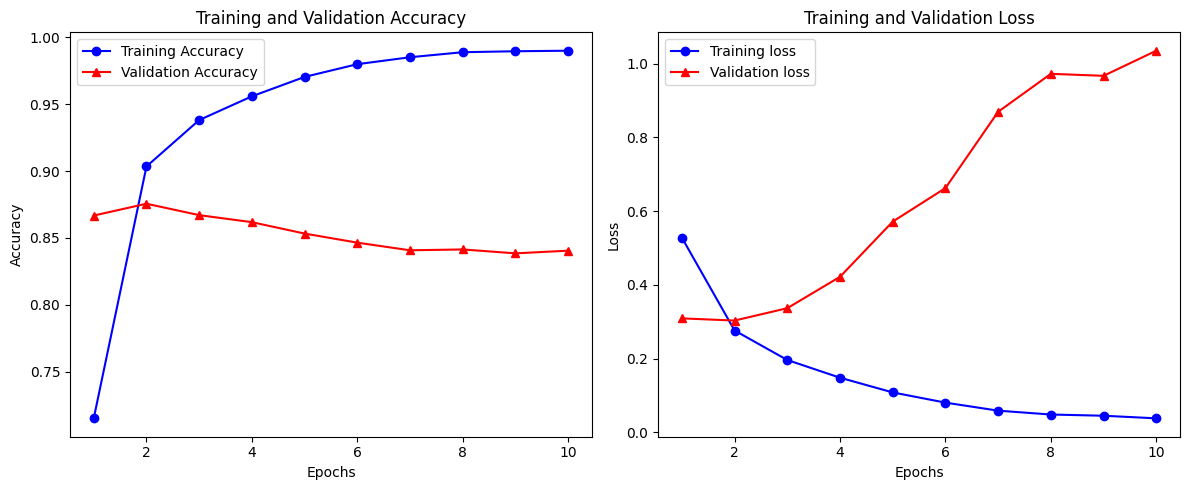

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_dict['loss']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy')
ax[0].plot(epochs, history_dict['val_accuracy'], 'r^-', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs, history_dict['loss'], 'bo-', label='Training loss')
ax[1].plot(epochs, history_dict['val_loss'], 'r^-', label='Validation loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

fig.tight_layout()
plt.show()

## Part 2 Vision Transformers

In [11]:
%%capture
!pip install --quiet vit-keras
!pip install -U tensorflow-addons

In [12]:
from vit_keras import vit
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Cat and Dogs dataset

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Ścieżka do datasetu na Google Drive
dataset_path = '/content/drive/MyDrive/Machine_Learning/dataset_split'

Mounted at /content/drive


In [16]:
from tensorflow.keras.preprocessing import  image_dataset_from_directory
import os

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
val_dir = os.path.join(dataset_path, 'validation')

train_dataset = image_dataset_from_directory(
    train_dir,  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

val_dataset = image_dataset_from_directory(
    val_dir,  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

test_dataset = image_dataset_from_directory(
    test_dir,  # This is the target directory
    labels="inferred",
    label_mode="binary", # Since we use binary_crossentropy loss, we need binary labels
    class_names=None,
    color_mode="rgb",
    batch_size=20,
    image_size=(150,150), # All images have different sizes and will be resized to 150x150
    shuffle=True,
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Functional api

In [41]:
data_augmentation = keras.Sequential(
    [
        layers.Resizing(224, 224),
        layers.Rescaling(1.0 / 255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
    ]
)

In [42]:
# Input layer
input_layer = layers.Input(shape=(150, 150, 3))

# Augmentation
augmented = data_augmentation(input_layer)

In [43]:
# Vision Transformer base model
vit_model = vit.vit_b32(
    image_size=224,
    activation=None,
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

vit_output = vit_model(augmented)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [44]:
# Add custom classification head
x = layers.Flatten()(vit_output)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

# Combine into a model
model = keras.Model(inputs=input_layer, outputs=output_layer)

In [45]:
# Compile the model
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [46]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
100/100 [==============================] - 1165s 11s/step - loss: 0.8141 - accuracy: 0.4790 - val_loss: 0.7121 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 31s 307ms/step - loss: 0.6989 - accuracy: 0.4960 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 31s 308ms/step - loss: 0.6948 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 36s 355ms/step - loss: 0.6943 - accuracy: 0.5080 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 31s 307ms/step - loss: 0.6944 - accuracy: 0.4995 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 6/10
100/100 [==============================] - 30s 300ms/step - loss: 0.6940 - accuracy: 0.4850 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
100/100 [==============================] - 30s 297ms/step - loss: 0.6933 - accuracy: 0.4920 - val_loss: 0.6932 - val_ac

In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

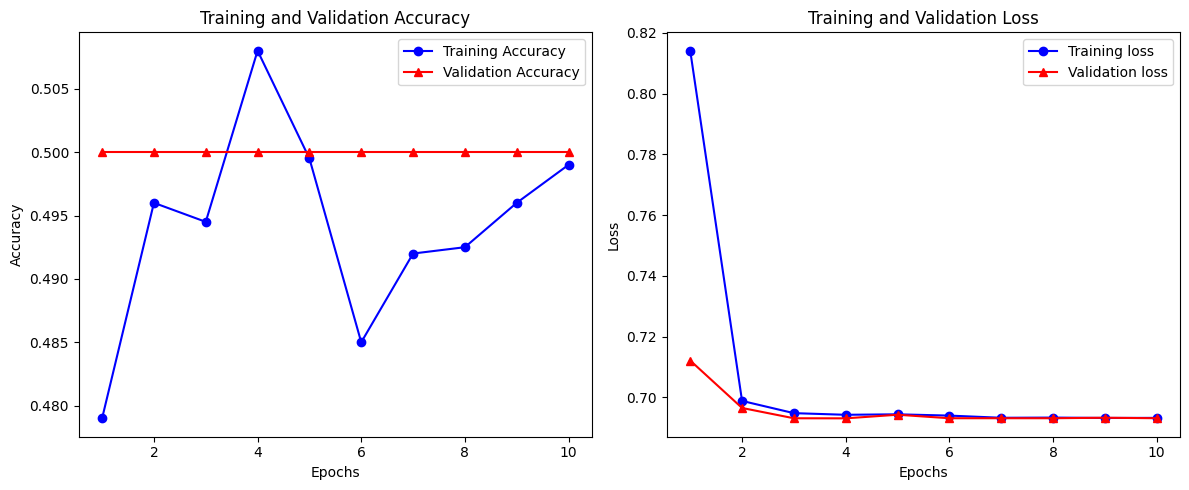

In [48]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_dict['loss']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(epochs, history_dict['accuracy'], 'bo-', label='Training Accuracy')
ax[0].plot(epochs, history_dict['val_accuracy'], 'r^-', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs, history_dict['loss'], 'bo-', label='Training loss')
ax[1].plot(epochs, history_dict['val_loss'], 'r^-', label='Validation loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

fig.tight_layout()
plt.show()

In [53]:
from vit_keras import visualize

# image = val_dataset.take(1) #todo load a single image
for image, label in val_dataset.take(1):
    image = image.numpy()
    break

resized_image = cv2.resize(image[0], (img_height, img_width))

attention_map = visualize.attention_map(model = vit_model, image = image)

#Attention map will be an oryginal image with some areas darker and some lighter. if you want to create a proper heatmap, you will need to manually apply a colormap.

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:3789: error: (-215:Assertion failed) !dsize.empty() in function 'resize'
